In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")

import torch
from torch import nn as nn
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
import torch.nn.functional as F
from matplotlib import gridspec
from sithcon import SITHCon_Layer, _SITHCon_Core, iSITH

from tqdm.notebook import tqdm

import itertools
from csv import DictWriter
import os 
from os.path import join
import glob

import numpy as np
import pandas as pd
import pickle
from math import factorial
import random

<class 'torch.cuda.FloatTensor'>


In [4]:
MORSE_CODE_DICT = { 'A':'.-', 'B':'-...', 
                    'C':'-.-.', 'D':'-..', 'E':'.', 
                    'F':'..-.', 'G':'--.', 'H':'....', 
                    'I':'..', 'J':'.---', 'K':'-.-', 
                    'L':'.-..', 'M':'--', 'N':'-.', 
                    'O':'---', 'P':'.--.', 'Q':'--.-', 
                    'R':'.-.', 'S':'...', 'T':'-', 
                    'U':'..-', 'V':'...-', 'W':'.--', 
                    'X':'-..-', 'Y':'-.--', 'Z':'--..', 
                    '1':'.----', '2':'..---', '3':'...--', 
                    '4':'....-', '5':'.....', '6':'-....', 
                    '7':'--...', '8':'---..', '9':'----.', 
                    '0':'-----', ', ':'--..--', '.':'.-.-.-', 
                    '?':'..--..', '/':'-..-.', '-':'-....-', 
                    '(':'-.--.', ')':'-.--.-'} 

In [5]:
print(MORSE_CODE_DICT['?'], MORSE_CODE_DICT['?'].replace('.', '10').replace('-', '1110'))
print()
morse_code_numpy = {key:np.array([int(x) for x in MORSE_CODE_DICT[key].replace('.', '10').replace('-', '1110')] + [0, 0])
                    for key in MORSE_CODE_DICT.keys()}
for k in morse_code_numpy.keys():
    #if len(morse_code_numpy[k]) == 12:
    #    print(morse_code_numpy[k], k)
    print(morse_code_numpy[k], k)
subset = list(morse_code_numpy.keys())
#subset = ['3', '7', 'Y', 'Q', 'J',
#          'M', 'R', 'U', 'H', 'D']

..--.. 1010111011101010

[1 0 1 1 1 0 0 0] A
[1 1 1 0 1 0 1 0 1 0 0 0] B
[1 1 1 0 1 0 1 1 1 0 1 0 0 0] C
[1 1 1 0 1 0 1 0 0 0] D
[1 0 0 0] E
[1 0 1 0 1 1 1 0 1 0 0 0] F
[1 1 1 0 1 1 1 0 1 0 0 0] G
[1 0 1 0 1 0 1 0 0 0] H
[1 0 1 0 0 0] I
[1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] J
[1 1 1 0 1 0 1 1 1 0 0 0] K
[1 0 1 1 1 0 1 0 1 0 0 0] L
[1 1 1 0 1 1 1 0 0 0] M
[1 1 1 0 1 0 0 0] N
[1 1 1 0 1 1 1 0 1 1 1 0 0 0] O
[1 0 1 1 1 0 1 1 1 0 1 0 0 0] P
[1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0] Q
[1 0 1 1 1 0 1 0 0 0] R
[1 0 1 0 1 0 0 0] S
[1 1 1 0 0 0] T
[1 0 1 0 1 1 1 0 0 0] U
[1 0 1 0 1 0 1 1 1 0 0 0] V
[1 0 1 1 1 0 1 1 1 0 0 0] W
[1 1 1 0 1 0 1 0 1 1 1 0 0 0] X
[1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0] Y
[1 1 1 0 1 1 1 0 1 0 1 0 0 0] Z
[1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] 1
[1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] 2
[1 0 1 0 1 0 1 1 1 0 1 1 1 0 0 0] 3
[1 0 1 0 1 0 1 0 1 1 1 0 0 0] 4
[1 0 1 0 1 0 1 0 1 0 0 0] 5
[1 1 1 0 1 0 1 0 1 0 1 0 0 0] 6
[1 1 1 0 1 1 1 0 1 0 1 0 1 0 0 0] 7
[1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0] 8

In [6]:
id2key = subset
key2id = {}
for idx, s in enumerate(subset):
    key2id[s] = idx

X = [ttype(morse_code_numpy[k])for k in subset]
Y = torch.LongTensor(np.arange(0,len(X)))
print(X, Y)

[tensor([1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.],
       device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
       device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0.,

In [12]:
sp1 = dict(in_features=2, 
           tau_min=.1, tau_max=500.0, buff_max=1000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=50, kernel_width=15, dilation=3, groups=2,
           dropout=None, batch_norm=None)
sith = _SITHCon_Core(sp1).cuda()
SL = SITHCon_Layer(sp1, act_func=nn.ReLU).cuda()
iv = X[0].unsqueeze(0).unsqueeze(0).unsqueeze(0).to('cuda')
iv = iv.unsqueeze(-1)
iv = iv.repeat(1,1,1,2,1)
iv = iv.reshape(1,1,2,-1)
print(iv.shape)

torch.Size([1, 1, 2, 8])


In [13]:
batch_size = iv.shape[0]
seq_size = iv.shape[-1]
x = sith.sith(iv)
print(x.shape)
# Swap sequence and features 
x = x.transpose(3,1)
print(x.shape)
x = sith.conv(x.reshape(-1, x.shape[2], x.shape[3]))
print(x.shape)
SL(iv).shape

torch.Size([1, 500, 2, 8])
torch.Size([1, 8, 2, 500])
torch.Size([8, 100, 458])


torch.Size([1, 1, 100, 8])

In [18]:
sp1 = dict(in_features=1, 
           tau_min=.1, tau_max=500.0, buff_max=1000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=50, kernel_width=15, dilation=3, groups=1,
           dropout=None, batch_norm=None)
sith = _SITHCon_Core(sp1).cuda()
SL = SITHCon_Layer(sp1, act_func=nn.ReLU).cuda()

In [19]:

iv = X[0].unsqueeze(0).unsqueeze(0).unsqueeze(0).to('cuda')

print(iv.shape)
#print(sith(iv).shape)
batch_size = iv.shape[0]
seq_size = iv.shape[-1]

x = sith.sith(iv)
print(x.shape)
# Swap sequence and features 
x = x.transpose(3,1)

print(x.shape)
x = sith.conv(x.reshape(-1, x.shape[2], x.shape[3]))
print(x.shape)
x = sith.maxp(x.squeeze(2))
print(x.shape)
x = x.reshape(batch_size, seq_size, -1)
print(x.shape)


torch.Size([1, 1, 1, 8])
torch.Size([1, 500, 1, 8])
torch.Size([1, 8, 1, 500])
torch.Size([8, 50, 458])
torch.Size([8, 50, 1])
torch.Size([1, 8, 50])


In [20]:
SL(iv).shape

torch.Size([1, 1, 50, 8])

In [25]:
sp1 = dict(in_features=2, 
           tau_min=.1, tau_max=500.0, buff_max=1000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=50, kernel_width=15, dilation=3, groups=2,
           dropout=None, batch_norm=None)
layer_params = [sp1]

model = SITHCon_Classifier(len(X), layer_params, act_func=nn.ReLU).cuda()
iv = X[0].unsqueeze(0).unsqueeze(0).unsqueeze(0).to('cuda')
iv = iv.unsqueeze(-1)
iv = iv.repeat(1,1,1,2,1)
iv = iv.reshape(1,1,2,-1)
print(model(iv).shape)

torch.Size([1, 1, 100, 8])
torch.Size([1, 1, 50, 8])
torch.Size([1, 8, 43])


In [27]:
class SITHCon_Classifier(nn.Module):
    def __init__(self, out_classes, layer_params, 
                 act_func=nn.ReLU, batch_norm=False,
                 dropout=.2):
        super(SITHCon_Classifier, self).__init__()
        last_channels = layer_params[-1]['channels']
        temp_tran = []
        for l in layer_params:
            if l['groups'] == 1:
                temp_tran.append(nn.Linear(l['channels'], l['channels']))
            elif l['groups'] == l['in_features']: 
                temp_tran.append(nn.Linear(l['channels']*l['groups'], l['channels']))
        self.transform_linears = nn.ModuleList(temp_tran)
        
        self.sithcon_layers = nn.ModuleList([SITHCon_Layer(l, act_func) for l in layer_params])
        self.to_out = nn.Linear(last_channels, out_classes)
        
        
    def forward(self, inp):
        
        x = inp
        #out = []
        for i in range(len(self.sithcon_layers)):
            x = self.sithcon_layers[i](x)
            x = self.transform_linears[i](x[:,0,:,:].transpose(1,2))
            x = x.unsqueeze(1).transpose(2,3)

            #out.append(x.clone())
        x = x.transpose(2,3)[:, 0, :, :]
        #x = x.transpose(2,3)[:, 0, :, :]
        x = self.to_out(x)
        return x

# One Layer

In [10]:
Trainscale = 10
sp1 = dict(in_features=1, 
           tau_min=.1, tau_max=500.0, buff_max=1000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=50, kernel_width=15, dilation=3,
           dropout=None, batch_norm=None)
layer_params = [sp1]

model = SITHCon_Classifier(len(X), layer_params, act_func=nn.ReLU).cuda()
model
tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 5000
device='cuda'
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')

for epoch_idx in progress_bar:
    perfs = []
    losses = []
    model.train()
    for batch_idx, iv in enumerate(X):
        iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
        iv = iv.unsqueeze(-1)
        iv = iv.repeat(1,1,1,1,Trainscale)
        iv = iv.reshape(1,1,1,-1)
        tv = Y[batch_idx].to(device)
        optimizer.zero_grad()
        out = model(iv)
        loss = loss_func(out[:, -1, :],
                         torch.cuda.LongTensor([tv]))
        loss.backward()
        optimizer.step()
        
        perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                      tv).sum().item())
        #perfs = perfs[int(-loss_buffer_size/batch_size):]
        losses.append(loss.detach().cpu().numpy())
        #losses = losses[int(-loss_buffer_size/batch_size):]
        
        
        s = "{}:{:2} Loss: {:.4f}, Perf: {:.4f}"
        format_list = [epoch_idx, batch_idx, np.mean(losses), 
                       np.sum(perfs)/((len(perfs)))]
        s = s.format(*format_list)
        progress_bar.set_description(s)

Total Weights: 5543
SITHCon_Classifier(
  (transform_linears): ModuleList(
    (0): Linear(in_features=50, out_features=50, bias=True)
  )
  (sithcon_layers): ModuleList(
    (0): SITHCon_Layer(
      (sithcon): _SITHCon_Core(
        (sith): iSITH(ntau=500, tau_min=0.1, tau_max=500.0, buff_max=1000, dt=1, k=30, g=0.0)
        (conv): Conv2d(1, 50, kernel_size=(1, 15), stride=(1, 1), dilation=(1, 3), bias=False)
        (maxp): MaxPool1d(kernel_size=458, stride=458, padding=0, dilation=1, ceil_mode=False)
      )
      (act_func): ReLU()
    )
  )
  (to_out): Linear(in_features=50, out_features=43, bias=True)
)


KeyboardInterrupt: 

In [15]:
model.eval()
evald = []
for nr in range(1,20):
    perfs = []
    for batch_idx, iv in enumerate(X):
        iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
        iv = iv.unsqueeze(-1)
        iv = iv.repeat(1,1,1,1,nr)
        iv = iv.reshape(1,1,1,-1)
        tv = Y[batch_idx].to(device)
        out = model(iv)
        loss = loss_func(out[:, -1, :],
                         torch.cuda.LongTensor([tv]))


        perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                      tv).sum().item())
    print(nr, sum(perfs)/len(perfs))
    evald.append([nr, sum(perfs)/len(perfs)])

1 0.7906976744186046
2 0.9069767441860465
3 0.9302325581395349
4 0.9302325581395349
5 0.9302325581395349
6 0.9302325581395349
7 0.9302325581395349
8 0.9069767441860465
9 0.9069767441860465
10 0.9767441860465116
11 0.9069767441860465
12 0.9069767441860465
13 0.8372093023255814
14 0.7209302325581395
15 0.7209302325581395
16 0.627906976744186
17 0.6046511627906976
18 0.5348837209302325
19 0.4418604651162791


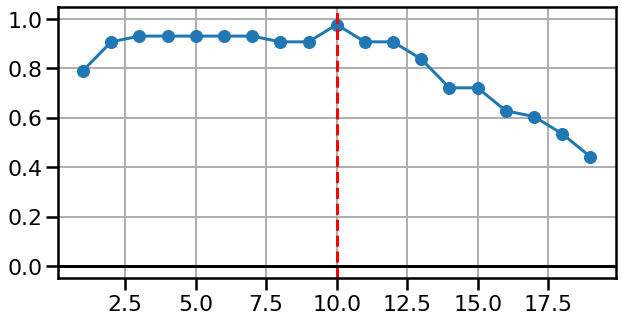

In [16]:
fig=plt.figure(figsize=(10,5))
plt.plot([e[0] for e in evald],
         [e[1] for e in evald],
         marker='o');

plt.axvline(Trainscale, color='red', linestyle='--')
plt.axhline(0, color='black')
plt.ylim(-.05, 1.05)
plt.grid()

# Three Layers

In [ ]:

sp1 = dict(in_features=1, 
           tau_min=.1, tau_max=1000.0, buff_max=2000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=35, kernel_width=15, dilation=3,
           dropout=None, batch_norm=None)
sp2 = dict(in_features=sp1['channels'], 
           tau_min=.1, tau_max=1000.0, buff_max=2000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=35, kernel_width=15, dilation=3, 
           dropout=None, batch_norm=None)
sp3 = dict(in_features=sp2['channels'], 
           tau_min=.1, tau_max=1000.0, buff_max=2000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=35, kernel_width=15, dilation=3, 
           dropout=None, batch_norm=None)
layer_params = [sp1, sp2, sp3]


model = SITHCon_Classifier(len(X), layer_params, act_func=nn.ReLU).cuda()
model
tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)

In [29]:

sp1 = dict(in_features=1, 
           tau_min=.1, tau_max=1000.0, buff_max=2000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=15, kernel_width=15, dilation=3,
           groups=1,
           dropout=None, batch_norm=None)
sp2 = dict(in_features=sp1['channels'], 
           tau_min=.1, tau_max=1000.0, buff_max=10000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=15, kernel_width=15, dilation=3,
           groups=sp1['channels'],
           dropout=None, batch_norm=None)
sp3 = dict(in_features=sp2['channels'], 
           tau_min=.1, tau_max=1000.0, buff_max=2000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=15, kernel_width=15, dilation=3, 
           groups=sp2['channels'],
           dropout=None, batch_norm=None)
layer_params = [sp1, sp2, sp3]

model = SITHCon_Classifier(len(X), layer_params, act_func=nn.ReLU).cuda()
model
tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)

Total Weights: 15148
SITHCon_Classifier(
  (transform_linears): ModuleList(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): Linear(in_features=225, out_features=15, bias=True)
    (2): Linear(in_features=225, out_features=15, bias=True)
  )
  (sithcon_layers): ModuleList(
    (0): SITHCon_Layer(
      (sithcon): _SITHCon_Core(
        (sith): iSITH(ntau=500, tau_min=0.1, tau_max=1000.0, buff_max=2000, dt=1, k=30, g=0.0)
        (conv): Conv1d(1, 15, kernel_size=(15,), stride=(1,), dilation=(3,), bias=False)
        (maxp): MaxPool1d(kernel_size=458, stride=458, padding=0, dilation=1, ceil_mode=False)
      )
      (act_func): ReLU()
    )
    (1): SITHCon_Layer(
      (sithcon): _SITHCon_Core(
        (sith): iSITH(ntau=500, tau_min=0.1, tau_max=1000.0, buff_max=10000, dt=1, k=30, g=0.0)
        (conv): Conv1d(15, 225, kernel_size=(15,), stride=(1,), dilation=(3,), groups=15, bias=False)
        (maxp): MaxPool1d(kernel_size=458, stride=458, padding=0, dilation=1, 

In [32]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
epochs = 5000
Trainscale = 10
device='cuda'
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')

for epoch_idx in progress_bar:
    perfs = []
    losses = []
    model.train()
    for batch_idx, iv in enumerate(X):
        iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
        iv = iv.unsqueeze(-1)
        iv = iv.repeat(1,1,1,1,Trainscale)
        iv = iv.reshape(1,1,1,-1)
        tv = Y[batch_idx].to(device)
        optimizer.zero_grad()
        out = model(iv)
        loss = loss_func(out[:, -1, :],
                         torch.cuda.LongTensor([tv]))
        loss.backward()
        optimizer.step()
        
        perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                      tv).sum().item())
        #perfs = perfs[int(-loss_buffer_size/batch_size):]
        losses.append(loss.detach().cpu().numpy())
        #losses = losses[int(-loss_buffer_size/batch_size):]
        
        
        s = "{}:{:2} Loss: {:.4f}, Perf: {:.4f}"
        format_list = [epoch_idx, batch_idx, np.mean(losses), 
                       np.sum(perfs)/((len(perfs)))]
        s = s.format(*format_list)
        progress_bar.set_description(s)

KeyboardInterrupt: 

In [33]:
model.eval()
evald = []
evaldDict = {'test_perf':[],
             'rate':[]}
for nr in [1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40]:
#for nr in range(1,40,):
    perfs = []
    for batch_idx, iv in enumerate(X):
        iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
        iv = iv.unsqueeze(-1)
        iv = iv.repeat(1,1,1,1,nr)
        iv = iv.reshape(1,1,1,-1)
        tv = Y[batch_idx].to(device)
        out = model(iv)
        loss = loss_func(out[:, -1, :],
                         torch.cuda.LongTensor([tv]))


        perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                      tv).sum().item())
    evaldDict['test_perf'].append(sum(perfs)/len(perfs))
    evaldDict['rate'].append(nr)
    print(nr, sum(perfs)/len(perfs))
    evald.append([nr, sum(perfs)/(len(perfs)*1.0)])

1 0.023255813953488372
2 0.06976744186046512
5 0.6976744186046512
6 0.9767441860465116
7 0.9767441860465116
8 1.0
9 1.0
10 1.0
11 1.0
12 1.0
13 1.0
14 1.0
15 1.0
16 0.9767441860465116
17 0.9767441860465116
18 0.9534883720930233
19 0.9302325581395349
20 0.9069767441860465
30 0.7674418604651163
40 0.6744186046511628


In [21]:
import pandas as pd
dat = pd.DataFrame(evaldDict)
dat.to_csv(join('perf','SITHCon_morse_perf.csv'))

In [22]:
dat1 = pd.read_csv(join('perf','SITHCon_morse_perf.csv'))
print(dat1)
dat2 = pd.read_csv(join('perf','DeepSITH_morse_perf.csv'))
dat2

    Unnamed: 0  test_perf  rate
0            0   0.186047     1
1            1   0.627907     2
2            2   1.000000     5
3            3   1.000000     6
4            4   1.000000     7
5            5   1.000000     8
6            6   1.000000     9
7            7   1.000000    10
8            8   1.000000    11
9            9   1.000000    12
10          10   1.000000    13
11          11   1.000000    14
12          12   1.000000    15
13          13   1.000000    16
14          14   1.000000    17
15          15   1.000000    18
16          16   1.000000    19
17          17   1.000000    20
18          18   1.000000    30
19          19   0.790698    40


,Unnamed: 0,test_perf,rate
0,0,0.000000,1
1,1,0.023256,2
2,2,0.023256,5
3,3,0.023256,6
4,4,0.046512,7
5,5,0.093023,8
6,6,0.534884,9
7,7,1.000000,10
8,8,0.465116,11
9,9,0.093023,12


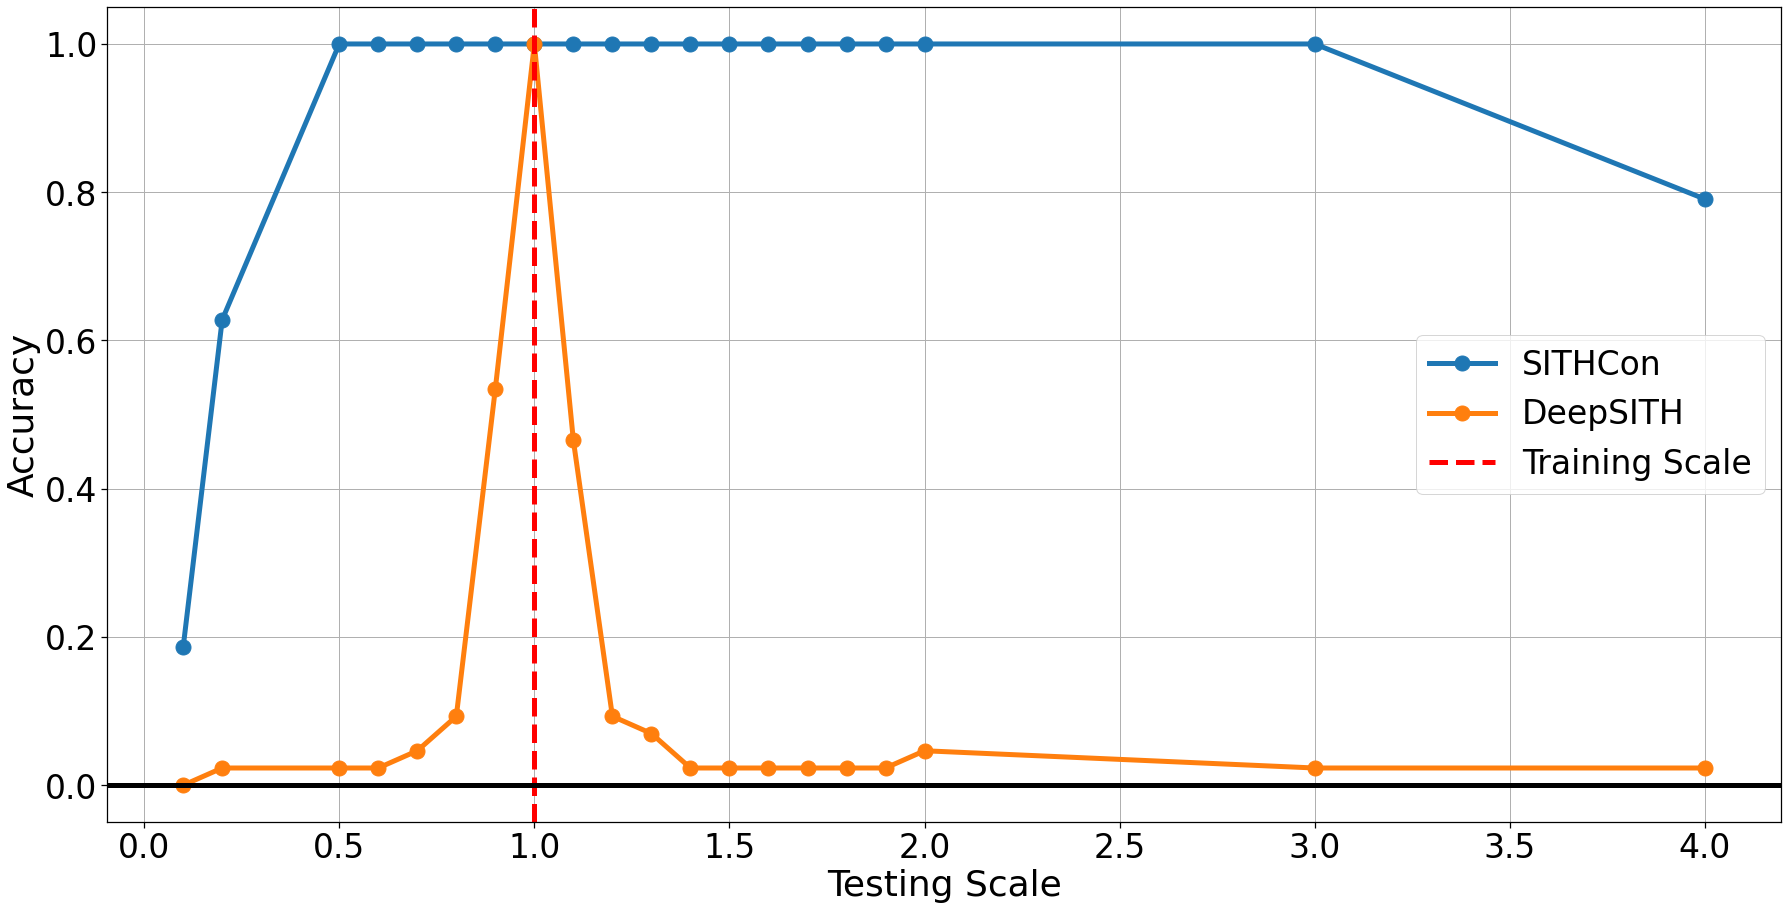

In [26]:
window_size = 20
lw=5
ms = 15
with sn.plotting_context("notebook", font_scale=3):
    fig=plt.figure(figsize=(30,15))
    Trainscale = 10
    plt.plot(dat1.rate/Trainscale, dat1.test_perf, marker='o',
            linewidth=lw, ms=ms)
    plt.plot(dat2.rate/Trainscale, dat2.test_perf, marker='o',
            linewidth=lw, ms=ms)
    plt.axvline(Trainscale/Trainscale, color='red', linestyle='--',
            linewidth=lw, ms=ms)
    plt.axhline(0, color='black',
            linewidth=lw, ms=ms)
    plt.ylim(-.05, 1.05)
    #plt.xscale('log')
    plt.grid()
    plt.ylabel('Accuracy')
    plt.xlabel('Testing Scale')
    plt.legend(['SITHCon', 'DeepSITH', 'Training Scale'])
plt.savefig(join('figs', 'perf3layers'), dpi=100)

In [30]:
import scipy.optimize as opt
from deepsith import iSITH
def min_fun(x, *args):
    ntau = args[2]
    k = int(x[0])
    if k < 4 or k>125:
        return np.inf
    tau_min = args[0]
    tau_max = args[1]    
    ev = iSITH(tau_min=tau_min, tau_max=tau_max, buff_max=tau_max*5, k=k, ntau=ntau, dt=1, g=1.0)    
    std_0 = ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1)[int(tau_min):int(tau_max)].std()
    std_1 = ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1, ::2].sum(1)[int(tau_min):int(tau_max)].std()    
    to_min = std_0/std_1
    return to_min

In [ ]:
ntau = 250
k_0 = 20
tau_min = .1
tau_max = 1000.
res = opt.minimize(min_fun, [k_0], args=(tau_min, tau_max, ntau), 
                   #method='Nelder-Mead',
                   method='Powell',
                   #method='L-BFGS-B',
                   #method='BFGS',
                   #method='CG',
                   #method='TNC',
                   bounds=[(4, 125)]
                  )
print(res)

k = int(res.x)
fig = plt.figure(figsize=(12,8))

print('ntau:', ntau, 'k:', k)

(-5.0, 3000.0)

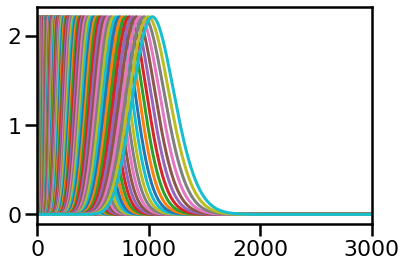

In [40]:
ev = iSITH(tau_min=tau_min, tau_max=tau_max, buff_max=tau_max*3, 
           k=30, ntau=ntau, dt=1.0, g=1.0)
#plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1, ::2].sum(1),
#        linewidth=8, color='grey');
#plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
#        linewidth=8, color='black');
plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
       );
#plt.ylim(-.05, 2.1)
plt.xlim(-5, 3*tau_max)
#plt.legend(["Total Sum", "Alternating Sum"])